In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import torch
from torch import nn, optim

In [2]:
from tqdm.notebook import tqdm

In [3]:
import torch.nn.functional as F

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")  

In [6]:
dataset_train = list()


# 1. Train Data Pairs
with open('train_job/train.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):

        if i == 0:
            pass
        else:
            dataset_train.append([line[0], line[1], int(line[2])])

# 2. Job id to number/ Job tags

job_dict = dict()

with open('train_job/job_tags.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):
        
        if i == 0:
            pass
        else:
            try:
                job_dict[line[0]].append(line[1])
            except KeyError:
                job_dict[line[0]] = [line[1]]
                
# 3. Job id to company code and size. Not using right now
                
company_set = set()
jobs_set = set()
company_size_set = set()
job_id_to_com_size_dict = dict()

scales = {'': 0, 
          '1-10': 1, 
          '11-50': 2, 
          '51-100': 3, 
          '101-200': 4, 
          '201-500': 5, 
          '501-1000': 6, 
          '1000 이상': 7}

with open('train_job/job_companies.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):
        
        if i == 0:
            pass
#             print(line)
        else:
            company_set.add(line[0])
            jobs_set.add(line[1])
            company_size_set.add(line[2])
            job_id_to_com_size_dict[line[1]] = scales[line[2]]

# 4. User skills
            
user_dict = dict()

with open('train_job/user_tags.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):
        
        if i != 0:
    
            try:
                user_dict[line[0]].append(line[1])
            except KeyError:
                user_dict[line[0]] = [line[1]]

# 5. Job required skills
                
tag_dictionary = dict()
tag_idx_to_tag_list = list()

with open('train_job/tags.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):
        
        if i != 0:
            tag_dictionary[line[0]] = i - 1
            tag_idx_to_tag_list.append(line)
            assert len(tag_idx_to_tag_list) == i
    
def tagID2Vector(tag_list):
    vector = np.zeros(len(tag_dictionary))
    
    for tag in tag_list:
        vector[tag_dictionary[tag]] = 1
    
    return vector

def jobID2Vector(job_id):
    vector = np.zeros(len(tag_dictionary))
    for tag in job_dict[job_id]:
        vector[tag_dictionary[tag]] = 1
    assert np.sum(vector) == len(job_dict[job_id]), f'{np.sum(vector)} != {len(job_dict[job_id])}'
    return vector

def jobID2CompanyScale(job_id):
    vector = np.zeros(len(tag_dictionary))
    for tag in job_dict[job_id]:
        vector[tag_dictionary[tag]] = 1
    assert np.sum(vector) == len(job_dict[job_id]), f'{np.sum(vector)} != {len(job_dict[job_id])}'
    return vector

In [7]:
for job in job_dict:
    assert len(job_dict[job]) == len(set(job_dict[job]))

In [8]:
def collate_function(data_input):

    global user_dict
    
    person_id_list = list()
    job_id_list = list()
    answer = list()

    for data in data_input:
        person_id_list.append(data[0])
        job_id_list.append(data[1])
        answer.append(data[2])
    
    person_tensor = list()
    for person_id in person_id_list:
        user_skill_set = set(user_dict[person_id])
        vector = tagID2Vector(user_skill_set)
        person_tensor.append(vector)
    person_tensor = torch.tensor(person_tensor)
        
    job_tensor = list()
    for job_id in job_id_list:
        vector = jobID2Vector(job_id)
        job_tensor.append(vector)
    job_tensor = torch.tensor(job_tensor)
        
    answer_tensor = torch.tensor(answer)
      
    com_size_tensor = list()
    for job_id in job_id_list:
        com_size_tensor.append(job_id_to_com_size_dict[job_id])
    com_size_tensor = torch.unsqueeze(torch.tensor(com_size_tensor), 1) / 7
    
        
    return person_tensor, job_tensor, answer_tensor, com_size_tensor

In [9]:
dataloader = DataLoader(dataset_train, 
                        batch_size=12, 
                        shuffle=True, 
                        num_workers=4, 
                        collate_fn=collate_function)

In [27]:
class NetZero(nn.Module):
    def __init__(self):
        super(NetZero, self).__init__()

    def forward(self, tensor, c_tensor=None):
        
        tensor = torch.zeros(tensor.shape[0], 2)

        tensor[:, 0] = 1
        
        return tensor

class NetOne(nn.Module):
    def __init__(self):
        super(NetOne, self).__init__()

    def forward(self, tensor, c_tensor=None):
        
        tensor = torch.zeros(tensor.shape[0], 2)

        tensor[:, 1] = 1
        
        return tensor


In [28]:
def accuracy(pred, label):
    
    assert len(pred) == len(label)
    
#     pred_label = np.floor(pred + 0.5)
    
    acc = 0
    
#     print(pred, label)
    
#     for i in range(len(pred)):
#         if pred_label[i] == label[i]:
#             acc += 1

#     return acc / len(pred_label)

    label_pred = [np.argmax(elem) for elem in pred]
    
    for i in range(len(pred)):
        if label_pred[i] == label[i]:
            acc += 1
            
    return acc / len(label_pred)

/home/joowhan/anaconda3/envs/DeepDarkEnv/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/joowhan/anaconda3/envs/DeepDarkEnv/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/joowhan/anaconda3/envs/DeepDarkEnv/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/joowhan/anaconda3/envs/DeepDarkEnv/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct f

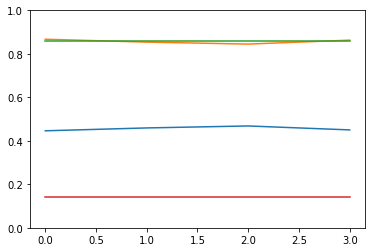

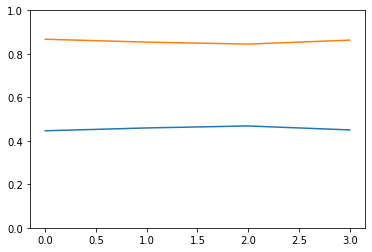

Acc. 0.8572607260726072
Loss 0.45600084658011353


In [29]:
# 모델 초기화
model = NetZero().to(device)

# 옵티마이저 초기화
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# weights = [1.0, 6.0]
# weights = [1.0, 24.0]
weights = [1.0, 1.0]
# weights = [1.0, 12.0]

class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

# criterion = nn.CrossEntropyLoss()

loss_history = list()
acc_history = list()

running_loss = list()
running_acc = list()

for j in range(1):

    for i, (p_tensor, j_tensor, a_tensor, c_tensor) in tqdm(enumerate(dataloader)):

    #     print(i)
    #     print(p_tensor.shape)
    #     print(j_tensor.shape)
    #     print(a_tensor.shape)

        p_tensor = torch.tensor(p_tensor, dtype=torch.float32)
        j_tensor = torch.tensor(j_tensor, dtype=torch.float32)
        c_tensor = torch.tensor(c_tensor, dtype=torch.float32)
        a_tensor = torch.tensor(a_tensor, dtype=torch.int64)

        s_tensor = torch.clamp(j_tensor - p_tensor, 0, 1)

        input_tensor = torch.cat((p_tensor, j_tensor, s_tensor), 1)

        model.zero_grad()

        pred_tensor = model(input_tensor.to(device), c_tensor.to(device))

    #     pred_tensor = torch.tensor(pred_tensor, dtype=torch.float64)

    #     print(pred_tensor.dtype)
    #     print(a_tensor.dtype)

        loss = criterion(pred_tensor.to(device), a_tensor.to(device))
#         loss.backward()
#         optimizer.step()

        running_loss.append(loss.item())
        running_acc.append(accuracy(pred_tensor.cpu().detach().numpy(), 
                           a_tensor.cpu().detach().numpy()))
        
        if len(running_loss) > 100:
            loss_history.append(np.mean(running_loss))
            acc_history.append(np.mean(running_acc))
            running_loss = list()
            running_acc = list()
    
    plt.figure()
    plt.plot(loss_history)
    plt.plot(acc_history)
    plt.plot([0.8571] * len(acc_history))
    plt.plot([0.1428] * len(acc_history))
    plt.ylim([0, 1])
    plt.show()
    
    plt.figure()
    plt.plot(loss_history)
    plt.plot(acc_history)
    plt.ylim([0, 1])
    plt.show()
    
    print(f'Acc. {np.mean(acc_history[-5:])}')
    print(f'Loss {np.mean(loss_history[-5:])}')

/home/joowhan/anaconda3/envs/DeepDarkEnv/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/joowhan/anaconda3/envs/DeepDarkEnv/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/joowhan/anaconda3/envs/DeepDarkEnv/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/joowhan/anaconda3/envs/DeepDarkEnv/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct f

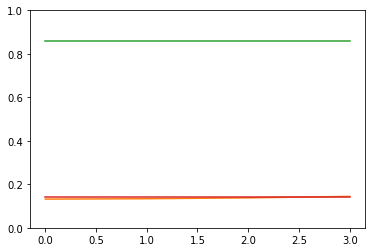

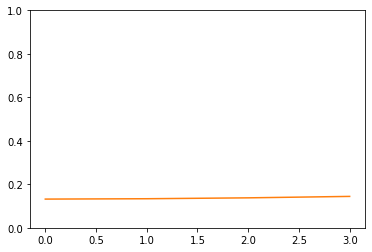

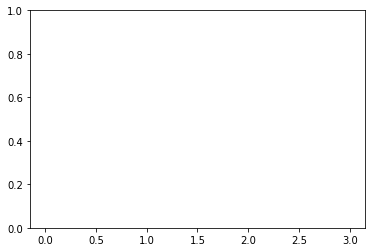

Acc. 0.13696369636963696
Loss 1.1762980417449875


In [31]:
# 모델 초기화
model = NetOne().to(device)

# 옵티마이저 초기화
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# weights = [1.0, 6.0]
weights = [1.0, 1.0]
# weights = [1.0, 12.0]

class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

# criterion = nn.CrossEntropyLoss()

loss_history = list()
acc_history = list()

running_loss = list()
running_acc = list()

for j in range(1):

    for i, (p_tensor, j_tensor, a_tensor, c_tensor) in tqdm(enumerate(dataloader)):

    #     print(i)
    #     print(p_tensor.shape)
    #     print(j_tensor.shape)
    #     print(a_tensor.shape)

        p_tensor = torch.tensor(p_tensor, dtype=torch.float32)
        j_tensor = torch.tensor(j_tensor, dtype=torch.float32)
        c_tensor = torch.tensor(c_tensor, dtype=torch.float32)
        a_tensor = torch.tensor(a_tensor, dtype=torch.int64)

        s_tensor = torch.clamp(j_tensor - p_tensor, 0, 1)

        input_tensor = torch.cat((p_tensor, j_tensor, s_tensor), 1)

        model.zero_grad()

        pred_tensor = model(input_tensor.to(device), c_tensor.to(device))

    #     pred_tensor = torch.tensor(pred_tensor, dtype=torch.float64)

    #     print(pred_tensor.dtype)
    #     print(a_tensor.dtype)

        loss = criterion(pred_tensor.to(device), a_tensor.to(device))
#         loss.backward()
#         optimizer.step()

        running_loss.append(loss.item())
        running_acc.append(accuracy(pred_tensor.cpu().detach().numpy(), 
                           a_tensor.cpu().detach().numpy()))
        
        if len(running_loss) > 100:
            loss_history.append(np.mean(running_loss))
            acc_history.append(np.mean(running_acc))
            running_loss = list()
            running_acc = list()
    
    plt.figure()
    plt.plot(loss_history)
    plt.plot(acc_history)
    plt.plot([0.8571] * len(acc_history))
    plt.plot([0.1428] * len(acc_history))
    plt.ylim([0, 1])
    plt.show()
    
    plt.figure()
    plt.plot(loss_history)
    plt.plot(acc_history)
    plt.ylim([0, 1])
    plt.show()
    
    plt.figure()
    plt.plot(loss_history)
    plt.ylim([0, 1])
    plt.show()
    
    print(f'Acc. {np.mean(acc_history[-5:])}')
    print(f'Loss {np.mean(loss_history[-5:])}')